In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from IPython.display import display

import segmentation_models as sm

In [26]:
class CFG:
    debug=True

    dataset_dir="../input/ranzcr-clip-catheter-line-classification/" if debug \
        else "gs://kds-8e853601547c2d2e7a243638123e66bb32174c3a2b50da35aca5baed/"
    annotated_tfrec="../input/cvc_annotated_mask.tfrec" if debug else "gs://km_kaggle_catheter/cvc_annotated_mask.tfrec"
    tfrec_length=8853
    batch_size=1 if debug else tpu_strategy.num_replicas_in_sync*8 
    input_size=(576,576)
    epochs=1 if debug else 200

In [48]:
feature_description={
    "StudyInstanceUID":tf.io.FixedLenFeature([],tf.string),
    "image":tf.io.FixedLenFeature([],tf.string)
}

def _parse_function(record):
    return tf.io.parse_example(record,feature_description)

AUTO=tf.data.experimental.AUTOTUNE

def decode_img(file_bytes):
    image=tf.io.decode_jpeg(file_bytes,channels=1)
    image=tf.image.resize(image,CFG.input_size)
    image/=255.0
    return image

def preprocess(record):
    annotated_img=decode_img(record["image"])
    uid=record["StudyInstanceUID"]
    original_path=f"{CFG.dataset_dir}train/"+uid+".jpg"
    original_img=decode_img(tf.io.read_file(original_path))
    return uid,original_img

def build_dataset(shuffle=256):
    dset=tf.data.TFRecordDataset([CFG.annotated_tfrec])
    dset=dset.skip(7100)
    dset=dset.map(_parse_function,num_parallel_calls=AUTO)
    dset=dset.map(preprocess,num_parallel_calls=AUTO)
    dset=dset.cache()
    dset=dset.shuffle(shuffle) if shuffle else dset
    dset=dset.batch(CFG.batch_size,drop_remainder=True).prefetch(AUTO)
    return dset

dset=build_dataset()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [45]:
def create_model():
    custom_objects={
        "iou_score":sm.metrics.IOUScore,
        "binary_crossentropy_plus_jaccard_loss":sm.losses.bce_jaccard_loss
    }
    model=tf.keras.models.load_model("./models/pspnet_ckpt", custom_objects=custom_objects)
    # model=sm.PSPNet(classes=1,activation="sigmoid",encoder_weights=None,input_shape=CFG.input_size+(1,))
    # model.compile(optimizer="adam",loss=sm.losses.bce_jaccard_loss,metrics=[sm.metrics.iou_score])
    return model

pspnet=create_model()

In [52]:
def image_show(img,title):
    fig,ax=plt.subplots(1,1,figsize=(5,5))
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(title)
    save_dir="../input/cvc_pspnet_pred/"
    os.makedirs(save_dir,exist_ok=True)
    #fig.savefig(save_dir+title+".jpg")

def decode_uids(uids_tensor):
    uids_list=[]
    for uid_tensor in uids_tensor:
        uids_list.append(uid_tensor.numpy().decode())
    return uids_list

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


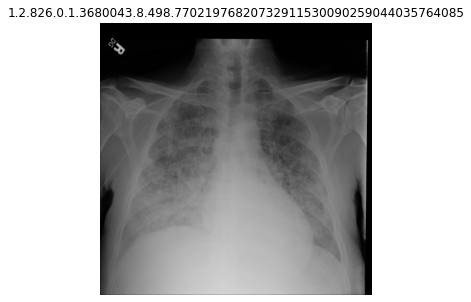

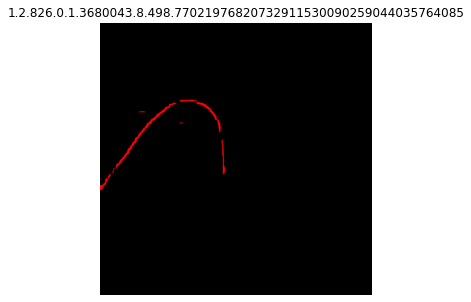

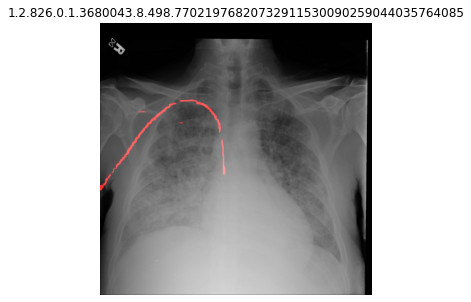

In [53]:
for uids,imgs in dset.take(1):
    preds=pspnet.predict(imgs)
    uids=decode_uids(uids)
    for uid,pred in zip(uids,preds):
        pred=pred.reshape(pred.shape[0],pred.shape[1])
        stacked_img=np.stack((pred,)*3,axis=-1)
        stacked_img[:,:,(1,2)]=0

        train_file_bytes=tf.io.read_file(f"../input/ranzcr-clip-catheter-line-classification/train/{uid}.jpg")
        train_img=tf.io.decode_jpeg(train_file_bytes,channels=3)
        train_img=tf.image.resize(train_img,(576,576))
        train_img/=255.0

        merged_img=train_img+stacked_img
        image_show(train_img,uid)
        image_show(stacked_img,uid)
        image_show(merged_img,uid)